![HSV-AI Logo](https://hsv.ai/wp-content/uploads/2022/03/logo_v11_2022.png)

# Implicit Recommendation from ECommerce Data

The dataset used for this work is from Kaggle [Vipin Kumar Transaction Data](https://www.kaggle.com/vipin20/transaction-data):

## Context

This is a item purchased transactions data. It has 8 columns.
This data makes you familer with transactions data.

## Content

Data description is :-

* UserId -It is a unique ID for all User Id
* TransactionId -It contains unique Transactions ID
* TransactionTime -It contains Transaction Time
* ItemCode -It contains item code that item will be purchased
* ItemDescription -It contains Item description
* NumberOfItemPurchased -It contains total number of items Purchased
* CostPerltem -Cost per item Purchased
* Country -Country where item purchased

## Basics of EDA

Here are a few things that we are looking for in the invoice / transaction data:

1. Were there any negative totals? If so why?
2. What percentage of the purchases actually contained multiple items?
3. What is the spread of purchases by customer ID? Do we have a few customers whose behavior may drive recommendations in a way that doesn't fit the average customer?
4. Where there any purchases that were VERY large? If so why? Do we want to include these values to train model behavior?
5. Is there any missing data that we need to scrub?


In [1]:
%reload_kedro

2022-03-26 22:21:37,710 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-03-26 22:21:37,736 - kedro.config.config - INFO - Config from path `/home/jlangley/git/product-recommendation/conf/vipin20` will override the following existing top-level config keys: alpha, factors, filter_value, iterations, maximum_order_size, minimum_order_size, regularization, seed, test_size, wandb_project
2022-03-26 22:21:37,737 - root - INFO - ** Kedro project productrec
2022-03-26 22:21:37,738 - root - INFO - Defined global variable `context`, `session` and `catalog`
2022-03-26 22:21:37,744 - root - INFO - Registered line magic `run_viz`


/home/jlangley/miniconda3/envs/product/lib/python3.8/site-packages/kedro/framework/context/context.py:488: UserWarning: Credentials not found in your Kedro project config.
No files found in ['/home/jlangley/git/product-recommendation/conf/base', '/home/jlangley/git/product-recommendation/conf/vipin20'] matching the glob pattern(s): ['credentials*', 'credentials*/**', '**/credentials*']
  warn(f"Credentials not found in your Kedro project config.\n{str(exc)}")


In [2]:
import pandas as pd
import numpy as np
import random
import scipy.sparse
from matplotlib import pyplot as plt
from pandas.api.types import CategoricalDtype


# Available Files

Let's go ahead and look into some of these files and see what we can see.

In [3]:
transactions = catalog.load("vipin20_kaggle_data")

transactions.head()

2022-03-26 22:21:37,935 - kedro.io.data_catalog - INFO - Loading data from `vipin20_kaggle_data` (CSVDataSet)...


,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom


# Checking for missing data

In [4]:
print('Total length is',len(transactions))
transactions.isna().sum()

Total length is 1083818


UserId                       0
TransactionId                0
TransactionTime              0
ItemCode                     0
ItemDescription           2908
NumberOfItemsPurchased       0
CostPerItem                  0
Country                      0
dtype: int64

In [5]:
transactions.describe()

,UserId,TransactionId,ItemCode,NumberOfItemsPurchased,CostPerItem
count,1.083818e+06,1.083818e+06,1.083818e+06,1.083818e+06,1.083818e+06
mean,2.410162e+05,6.159417e+06,6.582687e+05,2.865675e+01,9.498798e+00
std,1.423364e+05,1.476341e+05,4.526314e+05,6.542432e+02,2.308139e+03
min,-1.000000e+00,5.900015e+06,-1.000000e+00,-2.429850e+05,-1.526564e+04
25%,2.593920e+05,6.026856e+06,4.609080e+05,3.000000e+00,1.730000e+00
50%,3.020220e+05,6.166611e+06,4.752930e+05,9.000000e+00,2.880000e+00
75%,3.413550e+05,6.289569e+06,4.889430e+05,3.000000e+01,5.700000e+00
max,3.840270e+05,6.397457e+06,1.894494e+06,2.429850e+05,1.696285e+06


# -1 values for user & item?

Let's take a closer look at how many times a user or item shows up at -1. We will probably need to remove these items.

In [6]:
total_len = len(transactions)
bad_user_len = len(transactions[transactions["UserId"] == -1])
print("{} users set to -1 out of {} transactions, or {:.2f}%".format(bad_user_len, total_len, (bad_user_len / total_len * 100)))

bad_product_len = len(transactions[transactions["ItemCode"] == -1])
print("{} items set to -1 out of {} transactions, or {:.2f}%".format(bad_product_len, total_len, (bad_product_len / total_len * 100)))

270160 users set to -1 out of 1083818 transactions, or 24.93%
5592 items set to -1 out of 1083818 transactions, or 0.52%


In [7]:
# We can remove the -1 for items, since those will not be good to use for recommendation
transactions = transactions[transactions["ItemCode"] != -1]

There are 25303  transactions

Here are the product counts of transactions ordered from largest to smallest
[2226 1496 1460 ...    2    2    2]

And a graph of what the curve looks like:


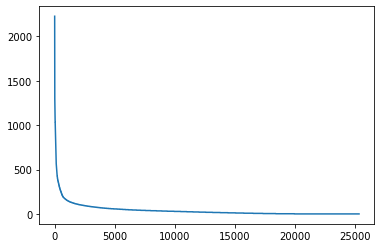

In [8]:
transaction_counts = transactions['TransactionId'].value_counts().to_numpy()
print('There are', len(transaction_counts), ' transactions\n')
print('Here are the product counts of transactions ordered from largest to smallest')
print(transaction_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(transaction_counts) 
plt.show()

# User Interactions

Let's take a look at how many unique customers are included in this dataset

There are 4364 unique customers

Here are the counts of transactions per customer ordered from largest to smallest
[268140  15942  11796 ...      2      2      2]

And a graph of what the curve looks like:


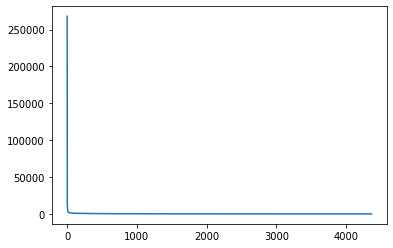

In [9]:
user_counts = transactions['UserId'].value_counts().to_numpy()
print('There are', len(user_counts), 'unique customers\n')
print('Here are the counts of transactions per customer ordered from largest to smallest')
print(user_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(user_counts) 
plt.show()

In [10]:
transactions.groupby(['UserId'])['UserId'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(10)

,UserId,count
0,-1,268140
4035,374661,15942
1893,313131,11796
1298,296016,10190
329,267708,9246
1672,306726,5556
2190,321531,4982
1701,307566,4132
567,274869,3714
696,278523,3344


It looks like "-1" is used when the customer is unknown. Let's take a look at the UserId with the very high count of items in the transactions.

In [11]:
transactions[transactions.UserId == 374661].groupby(transactions.TransactionId).count()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
TransactionId,,,,,,,,
5901973,4,4,4,4,4,4,4,4
5902127,130,130,130,130,130,130,130,130
5906769,4,4,4,4,4,4,4,4
5906824,58,58,58,58,58,58,58,58
5911455,92,92,92,92,92,92,92,92
...,...,...,...,...,...,...,...,...
6374676,316,316,316,316,316,316,316,316
6381496,250,250,250,250,250,250,250,250
6383245,58,58,58,58,58,58,58,58


It appears that there are a lot of different transactions, so probably not just the same thing being purchased over and over. Not really sure what to do with this at the moment.

# Transactions over Time

Now we need to look at the number of items purchased each day to see if there is anything interesting that pops out.

In [12]:
from datetime import datetime

datetime_object = datetime.strptime('Mon Feb 12 04:26:00 IST 2018', '%a %b %d %H:%M:%S IST %Y')

def func(date):
    temp = datetime.strptime(str(date), '%a %b %d %H:%M:%S IST %Y')
    return temp.strftime('%Y%m%d')

transactions['datetime'] = transactions.apply(lambda x: func(x.TransactionTime), axis=1)


<AxesSubplot:>

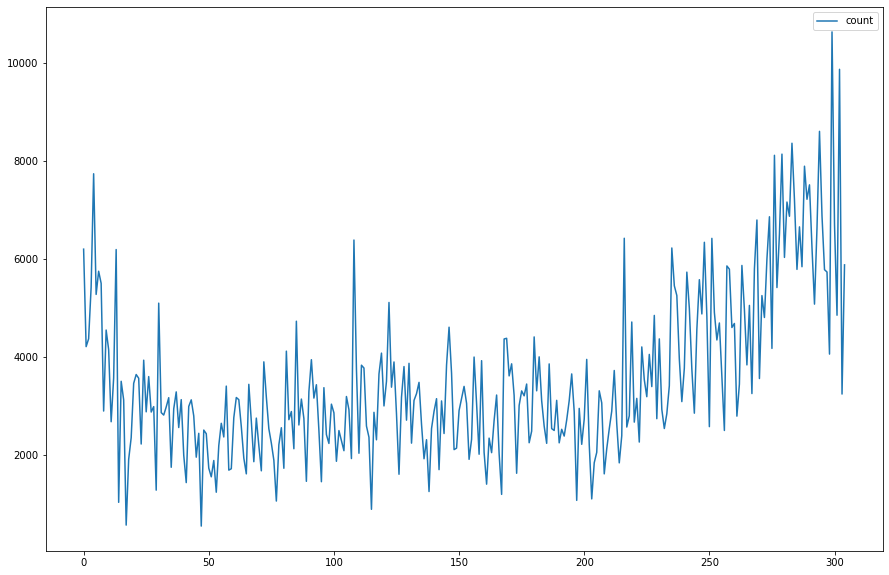

In [13]:
transactions.groupby(['datetime'])['datetime'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['datetime'], ascending=True) \
                             .plot(figsize=(15,10))

# Checking Invoice Totals

We need to make sure all the invoice totals that we're using are positive - this keeps us from using invoices that captured customer returned items.

<AxesSubplot:xlabel='TransactionId'>

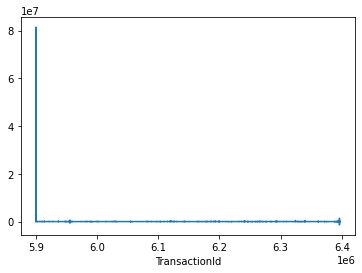

In [14]:
transactions['StockTotal'] = transactions['NumberOfItemsPurchased'] * transactions['CostPerItem']
totals = transactions.groupby(transactions.TransactionId)['StockTotal'].sum()
totals.plot()

In [15]:
totals.sort_values(ascending=False)

TransactionId
5900323    81421701.12
6396313     1399593.60
5955741      641217.60
6324351      439013.76
6340015      420050.34
              ...     
6186125      -36040.44
6276116      -98045.28
6055016     -190587.60
5955763     -641217.60
6396324    -1399593.60
Name: StockTotal, Length: 25303, dtype: float64

In [16]:
print('There are', len(transactions[transactions.NumberOfItemsPurchased < 0]), 'negative quantities')
transactions[transactions.NumberOfItemsPurchased < 0].head()

There are 20084 negative quantities


,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,datetime,StockTotal
69,300909,6015757,Tue May 29 14:14:00 IST 2018,466452,FOUR HOOK WHITE LOVEBIRDS,-3,2.90,United Kingdom,20180529,-8.70
135,319683,6036228,Sat Jun 16 08:28:00 IST 2018,470883,REGENCY CAKESTAND 3 TIER,-24,17.60,United Kingdom,20180616,-422.40
148,-1,6108674,Tue Aug 14 07:12:00 IST 2018,1780905,wet damaged,-288,0.00,United Kingdom,20180814,-0.00
329,321531,5925150,Sat Feb 24 11:05:00 IST 2018,446418,VICTORIAN SEWING BOX LARGE,-3,15.12,United Kingdom,20180224,-45.36
330,260715,6165940,Sun Sep 30 08:26:00 IST 2018,488061,TREASURE TIN GYMKHANA DESIGN,-3,2.88,Australia,20180930,-8.64


It looks like the negative quantities are driven by returned items. Let's see if anyone purchased and returned items in the same transaction:

In [17]:
temp_df = transactions.groupby(transactions.TransactionId).agg(minQ=('NumberOfItemsPurchased', 'min'), 
                               maxQ=('NumberOfItemsPurchased', 'max'))
temp_df[(temp_df.minQ < 0) & (temp_df.maxQ > 0)].head()

,minQ,maxQ
TransactionId,,


In [18]:
print('There are', len(transactions[transactions.CostPerItem < 0]), 'negative prices')
transactions[transactions.CostPerItem < 0].head()

There are 0 negative prices


,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,datetime,StockTotal


We can also check these transactions to see if there was a mix of negative prices along with positive.

In [19]:
temp_df = transactions.groupby(transactions.TransactionId).agg(minQ=('CostPerItem', 'min'), 
                               maxQ=('CostPerItem', 'max'))
temp_df[(temp_df.minQ < 0) & (temp_df.maxQ > 0)].head()

,minQ,maxQ
TransactionId,,


Now that we have identified the cause of negative totals, we can remove them so that they do not affect our model.

In [20]:
transactions = transactions[(transactions.NumberOfItemsPurchased > 0) & (transactions.CostPerItem > 0)]

Now we can check the totals that were much higher than average

In [21]:
transactions[transactions.TransactionId == 5900323].head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,datetime,StockTotal
320282,288687,5900323,Mon Feb 12 06:37:00 IST 2018,465780,RETROSPOT LAMP,24,1696285.44,United Kingdom,20180212,40710850.56
854978,288687,5900323,Mon Feb 12 06:37:00 IST 2018,465780,RETROSPOT LAMP,24,1696285.44,United Kingdom,20180212,40710850.56


In [22]:
transactions[transactions.TransactionId == 6396313].head()

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,datetime,StockTotal
510647,345366,6396313,Wed Feb 20 05:15:00 IST 2019,500703,"PAPER CRAFT , LITTLE BIRDIE",242985,2.88,United Kingdom,20190220,699796.8
691746,345366,6396313,Wed Feb 20 05:15:00 IST 2019,500703,"PAPER CRAFT , LITTLE BIRDIE",242985,2.88,United Kingdom,20190220,699796.8


It looks like there are two distinct cases where we may have an issue:

1. Extremely high priced items
2. Extremely high numbers of items purchased on the same transaction

We can remove both of these by just keeping the values within the 98% quantile

In [23]:
q = transactions["CostPerItem"].quantile(0.98)
transactions = transactions[transactions["CostPerItem"] < q]

In [24]:
q = transactions["NumberOfItemsPurchased"].quantile(0.98)
transactions = transactions[transactions["NumberOfItemsPurchased"] < q]

# Keeping single items for now


In [25]:
# minimum_order_size = 2
# order_group = transactions.loc[:, ['TransactionId', 'ItemCode']].groupby('TransactionId').count()
 
# multi_order = order_group[(order_group.ItemCode >= minimum_order_size)].count()
# single_order = order_group[(order_group.ItemCode < minimum_order_size)].count()
 
# print('Orders with at least',minimum_order_size,'products:',multi_order['ItemCode'])
# print('Orders with less than',minimum_order_size,'products:',single_order['ItemCode'])
 
# # We can capture the list of mutiple product orders with this:
# order_filter = order_group[(order_group.ItemCode >= minimum_order_size)].index.tolist()

Well it looks like this entire dataset has transactions with multiple products. No need to filter out transactions with only a single.

# Data Sparcity

Let's take a look at the sparcity of the data. This will tell us how many products were purchased across multiple orders. This is directly related to how well a recommendation system can be trained.

In [26]:
transaction_list = list(np.sort(transactions.TransactionId.unique())) # Get our unique customers
item_list = list(transactions.ItemCode.unique()) # Get our unique products that were purchased
quantity_list = list(transactions.NumberOfItemsPurchased) # All of our purchases

cols = transactions.TransactionId.astype(CategoricalDtype(categories=transaction_list, ordered=True)).cat.codes 
# Get the associated row indices
rows = transactions.ItemCode.astype(CategoricalDtype(categories=item_list, ordered=True)).cat.codes 
# Get the associated column indices
purchases_sparse = scipy.sparse.csr_matrix((quantity_list, (rows, cols)), shape=(len(item_list), len(transaction_list)))

In [27]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

99.21135117436835

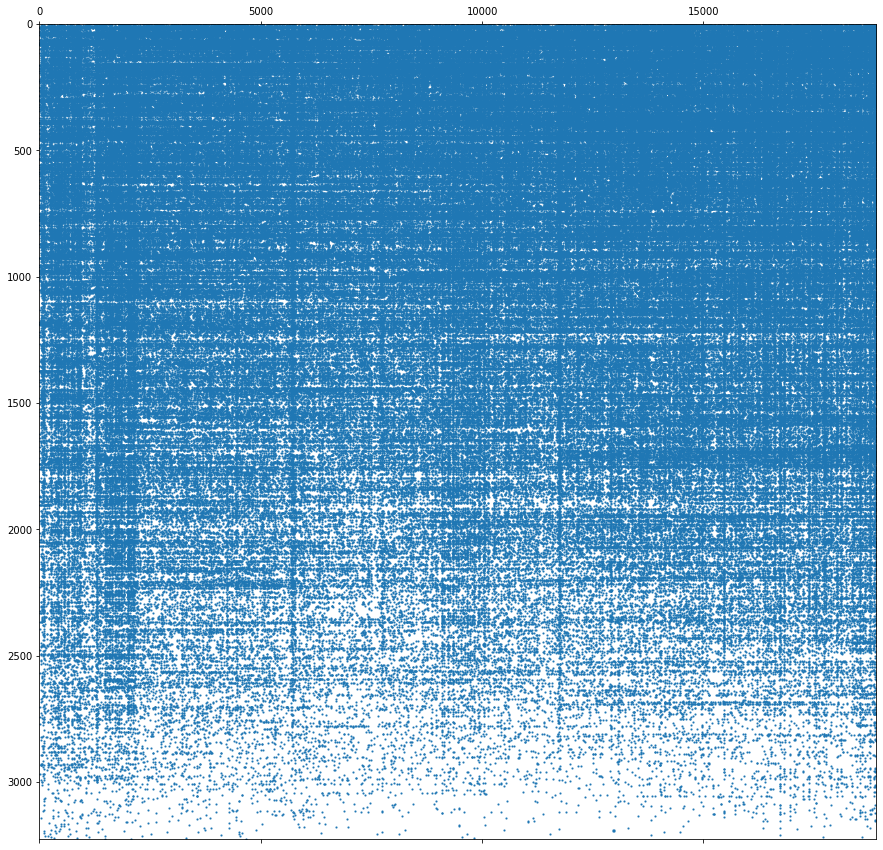

In [28]:
plt.figure(figsize=(15, 15))
plt.spy(purchases_sparse, markersize=1, aspect='auto')

# Storing Interim Data

Now that we have the data cleaned up a bit and formatted correctly, we can save it to an interim file to be picked up by the model training algorithm.

In [29]:
renamed_df = transactions.rename(columns={"TransactionId": "order_id", 
                        "ItemCode": "product_id",
                        "UserId": "customer_id",
                        "ItemDescription":"description",
                        "NumberOfItemsPurchased":"quantity",
                        "CostPerItem":"price"})[['order_id', 'product_id', 'customer_id', 'description', 'quantity', 'price']]


item_lookup = transactions[['ItemCode', 'ItemDescription']].drop_duplicates() # Only get unique item/description pairs
item_lookup['ItemCode'] = item_lookup.ItemCode.astype(str) # Encode as strings for future lookup ease

products_df = item_lookup.rename(columns={"ItemCode":"product_id", "ItemDescription":"description"})

catalog.save("transactions", renamed_df)

catalog.save("products", products_df)

2022-03-26 22:22:25,145 - kedro.io.data_catalog - INFO - Saving data to `transactions` (CSVDataSet)...
2022-03-26 22:22:28,081 - kedro.io.data_catalog - INFO - Saving data to `products` (CSVDataSet)...
